In [0]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv',delimiter='\t')

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from keras.utils import to_categorical
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
#Function to clean the dataset by removing non alphabetic characters, tokenization, lemmatization and removal of stopwords
def process_data(df):
    reviews = []

    for sent in df['Phrase']:
        review_text = re.sub("[^a-zA-Z]"," ", sent)
        words = word_tokenize(review_text.lower())
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        no_stop_words=[w for w in lemma_words if not w in stop_words]
        reviews.append(no_stop_words)

    return(reviews)

In [0]:
train_sentences = process_data(data)

In [0]:
#Converting the labels to one hot encode
target=data.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [0]:
#Function to find the size of vocabulary of the unique words and maximum length of a phrase for padding
unique_words = set()
len_max = 0

for sent in train_sentences:
    unique_words.update(sent)
    if(len_max<len(sent)):
        len_max = len(sent)

In [0]:
#Dividing training and testing into 70% and 30%
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(train_sentences, y_target, test_size=0.3, random_state=2003)

In [0]:
#Creating vocabulary for training and testing separately and padding them according to the maxlen.
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_train= sequence.pad_sequences(X_train, maxlen=len_max)
X_val = tokenizer.texts_to_sequences(X_val)
X_val= sequence.pad_sequences(X_val, maxlen=len_max)

In [0]:
from keras.layers import Conv1D, GlobalMaxPool1D, Dense, MaxPooling1D, Embedding, Activation, Input
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [0]:
#Early stopping to prevent the model from giving validation accuracy due to overfitting
early_stopping=EarlyStopping(min_delta=0.001, mode='max', monitor='val_acc',patience=0)
callback=[early_stopping]

In [12]:
model = Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(Conv1D(256, 2, activation="relu"))
model.add(MaxPooling1D())
model.add(GlobalMaxPool1D())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = "adam",metrics = ['accuracy'])
model.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 300)           4085100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 256)           153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 256)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)          

In [13]:
history=model.fit(X_train, Y_train, batch_size=300,epochs=50, verbose=1,validation_data=(X_val, Y_val),callbacks=callback)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 109242 samples, validate on 46818 samples
Epoch 1/50





109242/109242 [==============================] - 6s 55us/step - loss: 1.0108 - acc: 0.5968 - val_loss: 0.8634 - val_acc: 0.6481
Epoch 2/50
109242/109242 [==============================] - 4s 33us/step - loss: 0.7633 - acc: 0.6864 - val_loss: 0.8270 - val_acc: 0.6615
Epoch 3/50
109242/109242 [==============================] - 4s 33us/step - loss: 0.6592 - acc: 0.7216 - val_loss: 0.8475 - val_acc: 0.6547


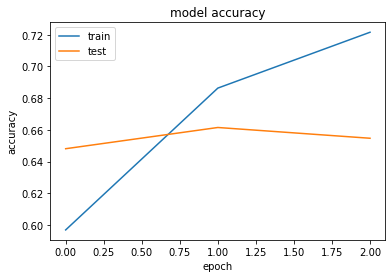

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

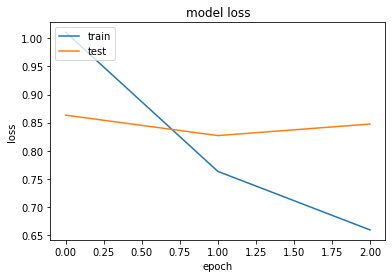

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
result=model.predict(X_val)
y_pred=result.argmax(axis=1)
Y_val=Y_val.argmax(axis=1)

In [17]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

print("Accuracy : "+ str(accuracy_score(Y_val, y_pred)))
print("Precisions : " + str(precision_score(Y_val, y_pred,average='weighted')))
print("Recall : "+ str(recall_score(Y_val, y_pred,average='weighted')))
print("F1 Score : " + str(f1_score(Y_val, y_pred,average='weighted')))

Accuracy : 0.6547054551668162
Precisions : 0.6592244224073915
Recall : 0.6547054551668162
F1 Score : 0.6524445269444893


In [0]:
model.save("1107179_1dcov_reg.h5")

In [0]:
#How to load my model
# import keras
# new = keras.models.load_model('1107179_1dcov_reg.h5')